In [9]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [37]:
data = pd.read_csv('OV2.csv', on_bad_lines='skip', sep=';')
data = pd.DataFrame(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21066 entries, 0 to 21065
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              21066 non-null  object 
 1   Streams           21066 non-null  int64  
 2   Viewers           21066 non-null  int64  
 3   Dominant_streams  21066 non-null  int64  
 4   Dominant_ratio    21066 non-null  float64
 5   Tags              21066 non-null  object 
 6   Name              21066 non-null  object 
 7   Title             21066 non-null  object 
 8   Beginning         21066 non-null  object 
 9   Holidays          21066 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 1.6+ MB


In [38]:
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data = data.dropna()
data['Hour'] = data['Date'].dt.hour
data['Minute'] = data['Date'].dt.hour
data['Weekday'] = data['Date'].dt.weekday
data['Moving_streams'] = data['Streams'].rolling(10, min_periods=1).mean()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21066 entries, 0 to 21065
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              21066 non-null  datetime64[ns]
 1   Streams           21066 non-null  int64         
 2   Viewers           21066 non-null  int64         
 3   Dominant_streams  21066 non-null  int64         
 4   Dominant_ratio    21066 non-null  float64       
 5   Tags              21066 non-null  object        
 6   Name              21066 non-null  object        
 7   Title             21066 non-null  object        
 8   Beginning         21066 non-null  object        
 9   Holidays          21066 non-null  int64         
 10  Hour              21066 non-null  int64         
 11  Minute            21066 non-null  int64         
 12  Weekday           21066 non-null  int64         
 13  Moving_streams    21066 non-null  float64       
dtypes: datetime64[ns](1), 

In [39]:
X = data[['Hour','Minute','Weekday','Holidays']]
y = data[['Moving_streams']]
#y = data[['Moving_streams']]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, shuffle=False)
y_test = y_test.reset_index()

In [41]:
xgb_model = xgb.XGBRegressor(n_estimators = 100)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

#For measuring accuracy 
y_pred = y_pred.astype(int)
y_test['Moving_streams'] = y_test['Moving_streams'].astype(int)



wynik = 0
wynik_list =[]
#For bigger games
# for i in range(len(y_test)):
#     temp = max(y_pred[i],y_test['Moving_streams'][i]) / min(y_pred[i],y_test['Moving_streams'][i])
#     temp = ((temp * 100) - 100) * 10
#     temp = 100 - temp
#     if temp > 0:
#         wynik += temp/100
#         wynik_list.append(temp)
#     else:
#         wynik += 0
#         wynik_list.append(0)

for i in range(len(y_test)):
    if y_test['Moving_streams'][i] == y_pred[i]:
        wynik += 1
        wynik_list.append(100)
    elif y_pred[i] == y_test['Moving_streams'][i] + 1 or  y_pred[i] == y_test['Moving_streams'][i] - 1:
        wynik += 0.5
        wynik_list.append(50)
    else:
        wynik += 0 
        wynik_list.append(0)

# For bigger games
# df = pd.DataFrame(y_pred)
# df['should'] = y_test['Moving_streams']
# df['result'] = wynik_list
# df.columns = ['is','should','result']
# display(df)

print(wynik/len(y_test))

df = pd.DataFrame(y_pred)
df['should'] = y_test['Moving_streams']
df['result'] = wynik_list
df.columns = ['is','should','result']
display(df)

# calculate MSE
mse = mean_squared_error(y_test['Moving_streams'], y_pred)
print("Mean squared error:", mse)


0.54739336492891


,is,should,result
0,3,3,100
1,3,3,100
2,3,3,100
3,3,3,100
4,3,3,100
...,...,...,...
206,10,10,100
207,10,10,100
208,10,10,100
209,10,10,100


Mean squared error: 3.4075829383886256


In [43]:
new_data = pd.DataFrame({'Hour': [17], 'Minute': [0], 'Weekday': [0], 'Holidays':[0]})
prediction = xgb_model.predict(new_data)

print('Score: ', prediction)

Score:  [1.3968129]


In [7]:
xgb_model.feature_importances_

array([0.93317616, 0.        , 0.06682386], dtype=float32)

In [23]:
from sklearn.ensemble import IsolationForest

X = data[['Hour','Minute','Weekday','Holidays','Moving_streams']]

isof = IsolationForest(n_estimators = 1000, contamination=0.04)
isof.fit(X)



c:\Users\tymot\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.04, n_estimators=1000)

In [24]:
new_data = pd.DataFrame({'Hour': [17], 'Minute': [0], 'Weekday': [0], 'Holidays':[0], 'Moving_streams': [6]})
display(new_data)
prediction = isof.predict(new_data)

print('Wynik: ', prediction)

,Hour,Minute,Weekday,Holidays,Moving_streams
0,17,0,0,0,6


Wynik:  [1]


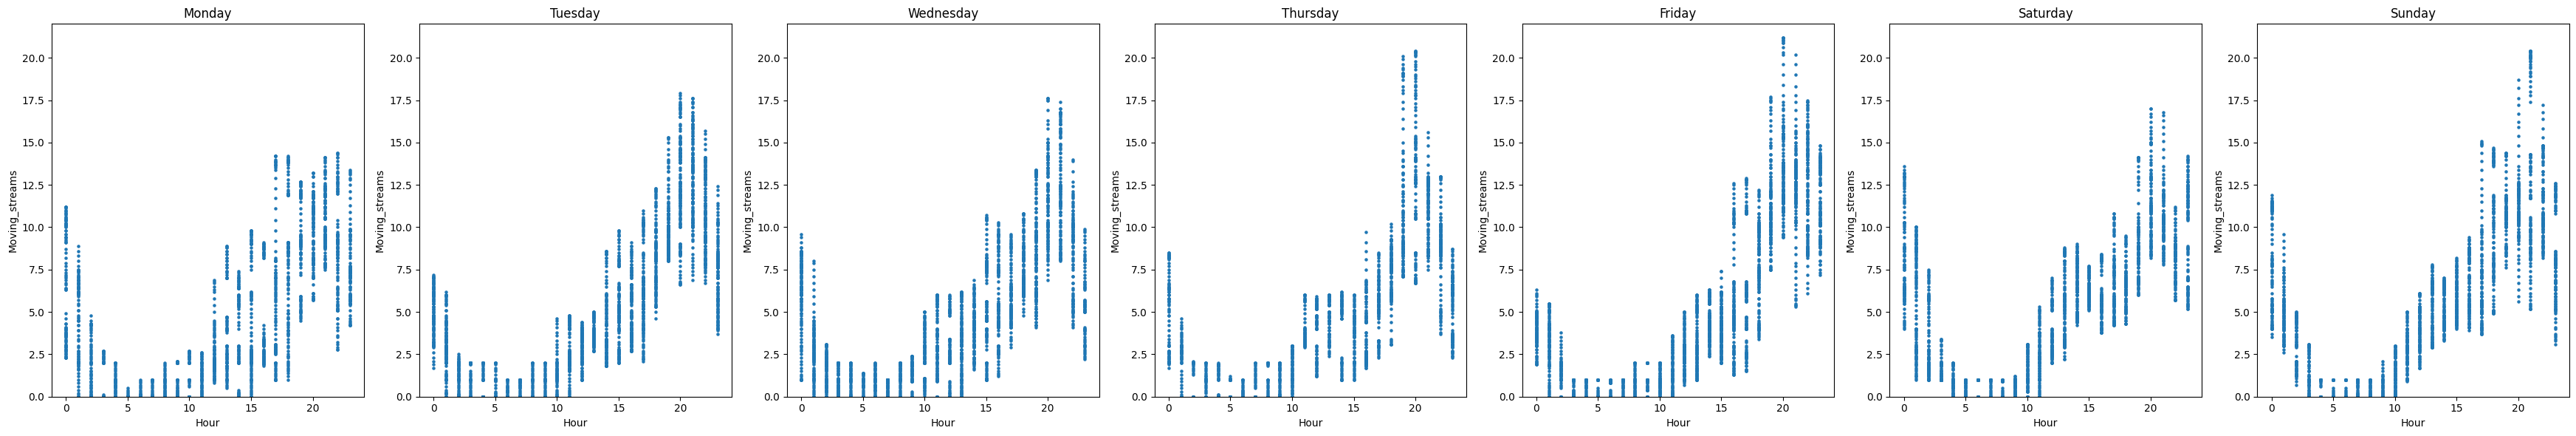

In [25]:
import matplotlib.pyplot as plt

# utwórz słownik, który przyporządkowuje nazwy dni tygodnia do ich numerów (poniedziałek=0, wtorek=1, itd.)
weekday_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# podziel dane na 7 grup według dni tygodnia i wygeneruj 7 wykresów rozproszenia (scatter plots)
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(35, 6))

for i in range(7):
    # wybierz tylko dane odpowiadające danemu dniowi tygodnia
    data_day = X[X['Weekday'] == i]
    
    # utwórz wykres rozproszenia w odpowiednim podwykresie
    axes[i].scatter(data_day['Hour'], data_day['Moving_streams'], s=5)
    axes[i].set_xlabel('Hour')
    axes[i].set_ylabel('Moving_streams')
    axes[i].set_title(weekday_dict[i])
    axes[i].set_ylim(bottom=0, top=22)

# wyświetl cały wykres z 7 podwykresami
plt.tight_layout()
plt.show()

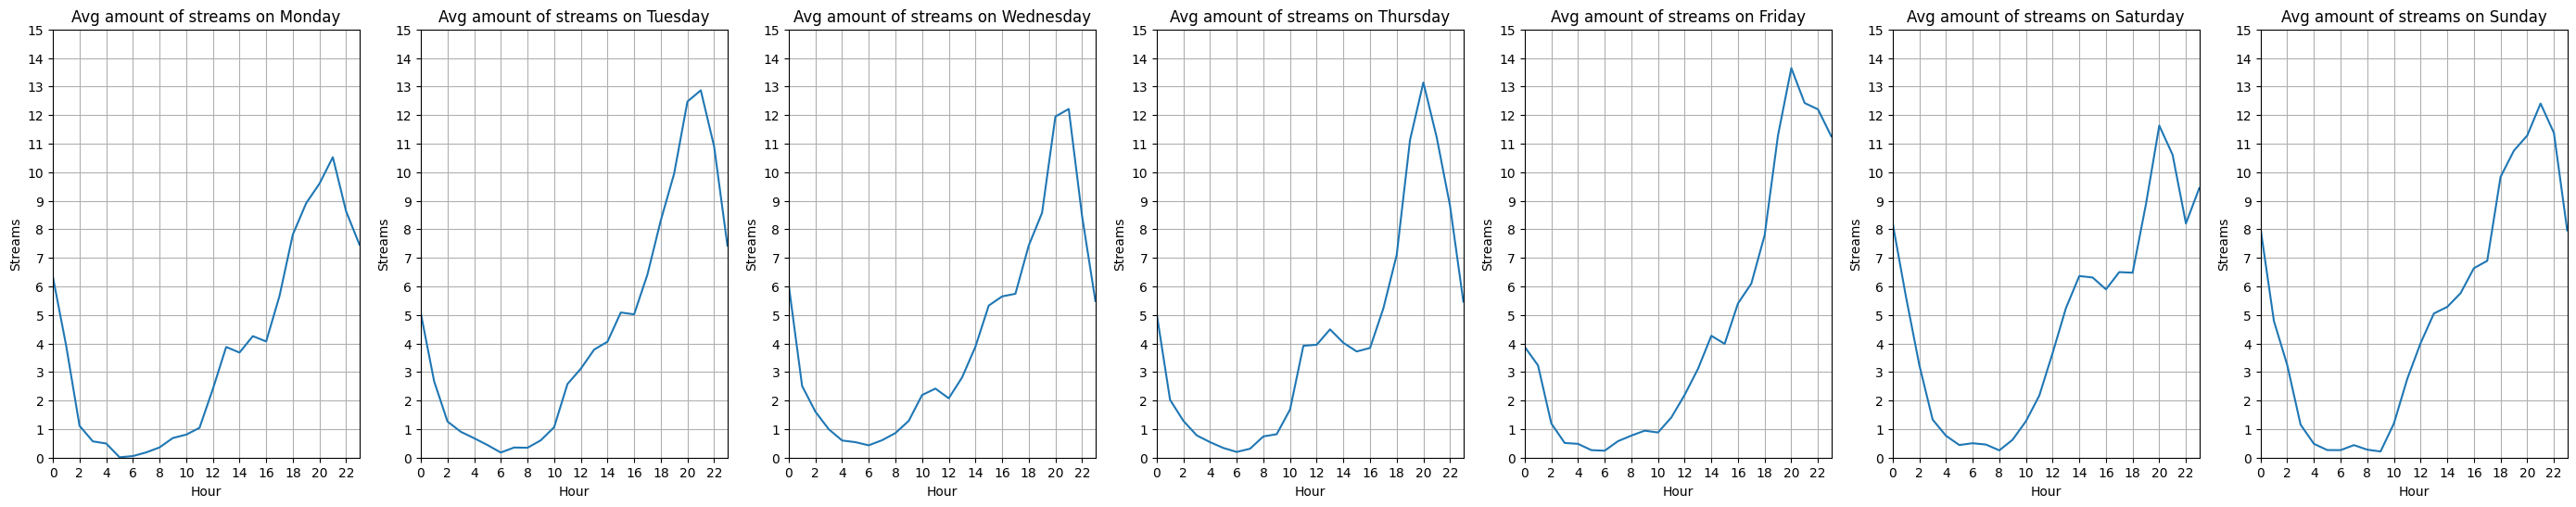

In [26]:
df_grouped = data.groupby(['Weekday', 'Hour'])['Moving_streams'].mean().reset_index()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

weeks_name = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(35, 6))

for i in weeks_name.keys():
    group = df_grouped[df_grouped['Weekday'] == i]
    sns.lineplot(data=group, x='Hour', y='Moving_streams', ax=axs[i])
    axs[i].set_title(f"Avg amount of streams on {weeks_name[i]}")
    axs[i].set_xlabel("Hour")
    axs[i].set_ylabel("Streams")
    axs[i].xaxis.set_major_locator(ticker.MultipleLocator(2))
    axs[i].yaxis.set_major_locator(ticker.MultipleLocator(1))
    axs[i].set_xlim(left=0, right=23)
    axs[i].set_ylim(bottom=0, top=15)
    axs[i].grid()
    
plt.show()

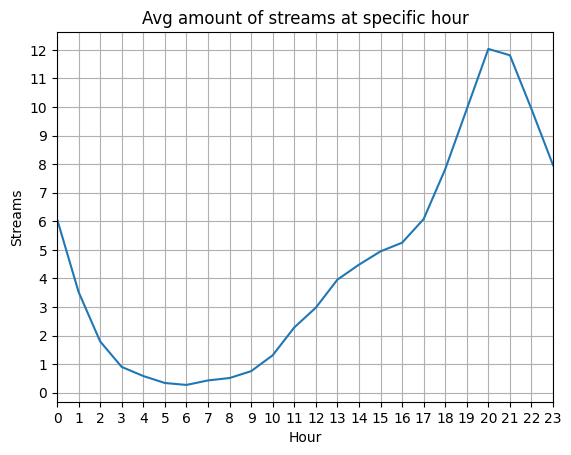

In [27]:
df_grouped = data.groupby(['Hour'])['Moving_streams'].mean().reset_index()

plt.plot(df_grouped['Hour'], df_grouped['Moving_streams'])
plt.title("Avg amount of streams at specific hour")
plt.xlabel("Hour")
plt.ylabel("Streams")
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().set_xlim(left=0, right=23)
plt.grid()